In [112]:
# -*- coding: utf-8 -*-
#  Copyright 2024 United Kingdom Research and Innovation
#  Copyright 2024 The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#



In [113]:
# Import libraries
  
from cil.optimisation.algorithms import  FISTA, ISTA
from cil.optimisation.functions import LeastSquares, SGFunction, BlockFunction, SumFunction

from cil.optimisation.algorithms import GD
from cil.optimisation.utilities import Sampler


from cil.io import ZEISSDataReader
 
from cil.processors import Slicer, Binner, TransmissionAbsorptionConverter
 
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
 
from cil.utilities.display import show2D
from cil.utilities import dataexample
 

 
import numpy as np
import matplotlib.pyplot as plt
import os

# Data information and set-up

We use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

    https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `path` variable below.

In [114]:
path = '../../data/walnut/valnut'

In [115]:
reader = ZEISSDataReader()
filename = "../data/valnut_tomo-A.txrm"
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1601,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

# A Least squares reconstruction with a fixed step size 

  0%|          | 0/100 [00:00<?, ?it/s]

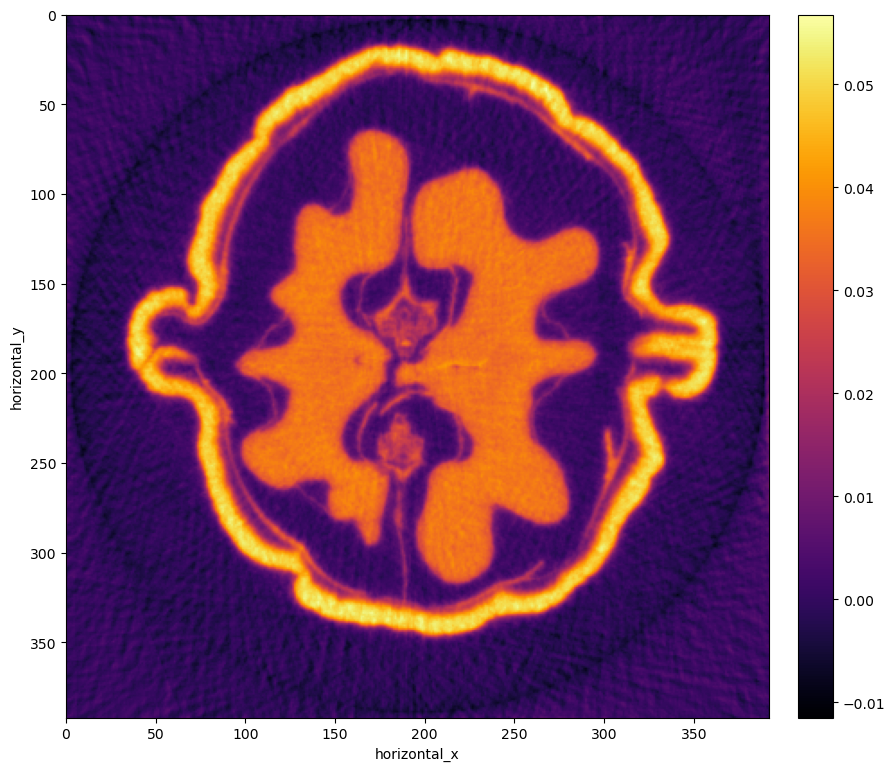

In [116]:
full_objective=(1/2)*LeastSquares(A, b=data)
myGD_LS = GD(initial=ig2D.allocate(0), 
             objective_function=full_objective, 
             step_size=1/full_objective.L, 
             max_iteration=100, 
             update_objective_interval=1)
myGD_LS.run(100, verbose=1)

show2D(myGD_LS.solution, cmap="inferno", origin="upper")

# A Least squares reconstruction with backtracking to choose the step-size

  0%|          | 0/100 [00:00<?, ?it/s]

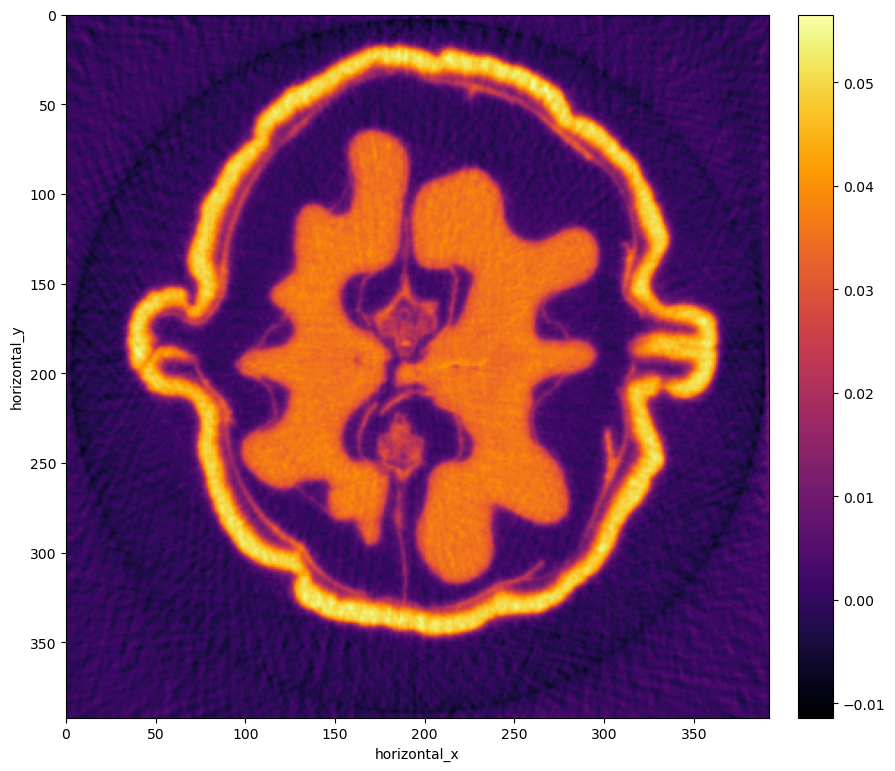

In [117]:
full_objective=(1/2)*LeastSquares(A, b=data)
myGD_LS_BT = GD(initial=ig2D.allocate(0), 
             objective_function=full_objective, 
             max_iteration=100, 
             update_objective_interval=1)
myGD_LS_BT.run(100, verbose=1)

show2D(myGD_LS_BT.solution, cmap="inferno", origin="upper")

#   Partition the data and define the functions in the separable sum
We need to define the following:

- The operator $A=(A_1,\dots,A_n)$.
- The functions $F=(F_1,\dots,F_N)$ 
- A stochastic sampler
- The Stochastic Gradient Sum Function 






In [118]:
# Define number of subsets
n_subsets = 80

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# partition the data and build the projectors
partitioned_data = data.partition(n_subsets, 'sequential')
A_partitioned = ProjectionOperator(ig2D, partitioned_data.geometry, device = "cpu")
# create the list of functions for the stochastic sum 
list_of_functions = [(1/2)*LeastSquares(Ai, b=bi) for Ai,bi in zip(A_partitioned, partitioned_data)]

#define the sampler and the stochastic gradient function 
sampler = Sampler.staggered(len(list_of_functions), stride=2)
f_stochastic = SGFunction(list_of_functions, sampler=sampler)  



  0%|          | 0/8000 [00:00<?, ?it/s]

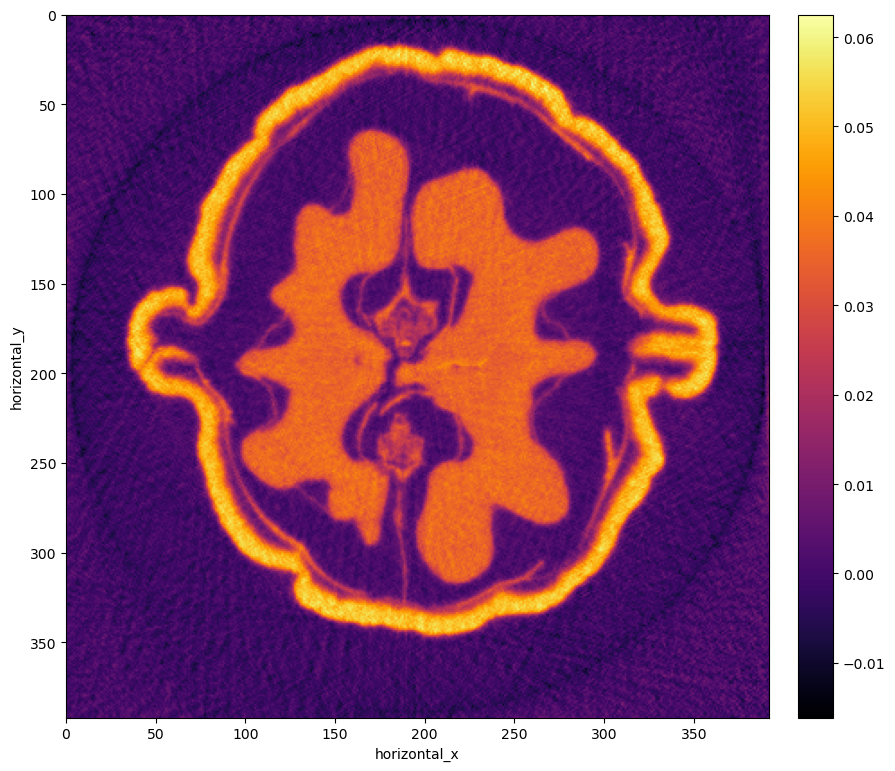

In [119]:

mySGD_LS_SG = GD(initial=ig2D.allocate(0), 
             objective_function=f_stochastic, 
             step_size=2/(n_subsets*f_stochastic.L), 
             max_iteration=100*n_subsets, 
             update_objective_interval=1*n_subsets)
mySGD_LS_SG.run(100*n_subsets, verbose=1)

show2D(mySGD_LS_SG.solution, cmap="inferno", origin="upper")

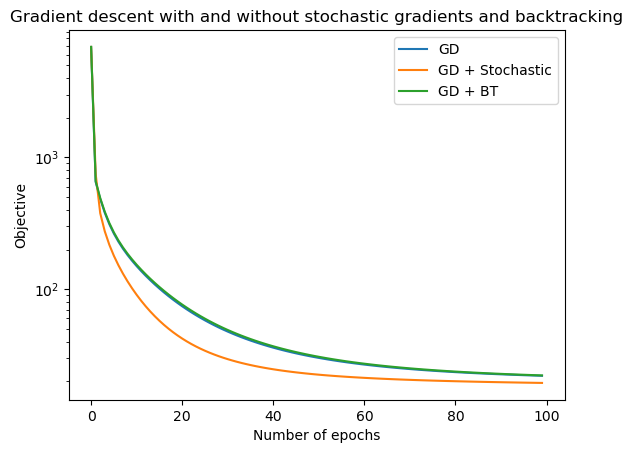

In [120]:
plt.figure()
plt.semilogy(range(0, 100, 1), myGD_LS.objective[1:101], label='GD' )
plt.semilogy(range(0, 100, 1), mySGD_LS_SG.objective[1:101], label='GD + Stochastic')
plt.semilogy(range(0, 100, 1), myGD_LS_BT.objective[1:101], label='GD + BT')

plt.xlabel('Number of epochs')
plt.ylabel('Objective')
plt.title('Gradient descent with and without stochastic gradients and backtracking')
plt.legend()
plt.show() 

# Repeat with FISTA and ISTA with TV regularisation 

  0%|          | 0/100 [00:00<?, ?it/s]

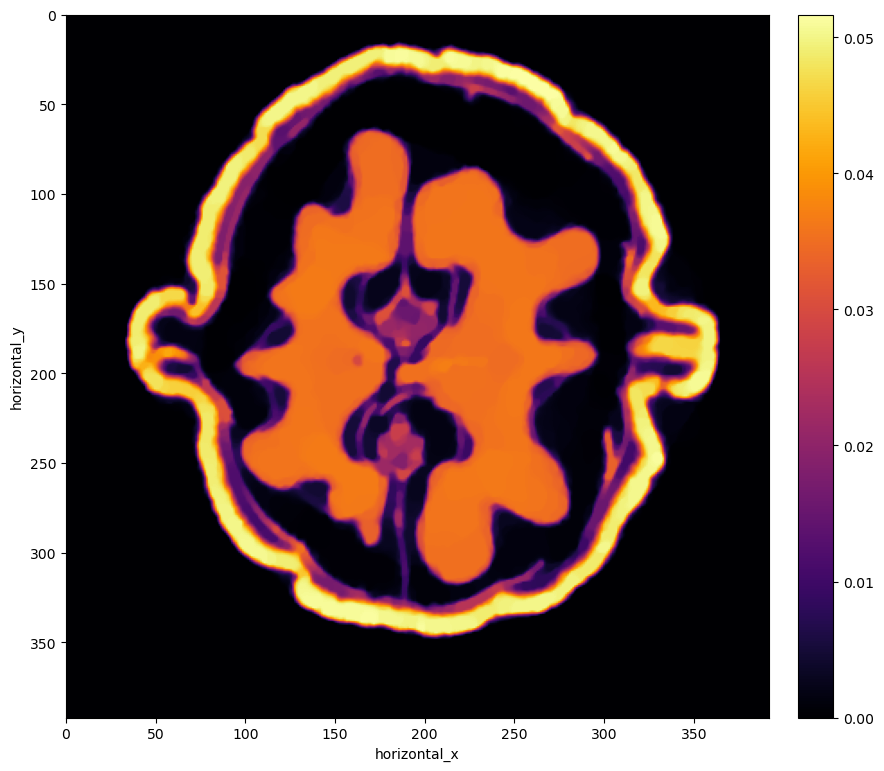

In [121]:
num_epochs=100
alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0)

step_size_ista = 0.99*2.0/(full_objective.L)

ista = ISTA(initial = initial, f=full_objective, step_size = step_size_ista, g=G, update_objective_interval = 1, 
            max_iteration = num_epochs)
ista.run(num_epochs, verbose=1)
optimal = ista.solution
show2D(ista.solution, cmap="inferno", origin="upper")

  0%|          | 0/100 [00:00<?, ?it/s]

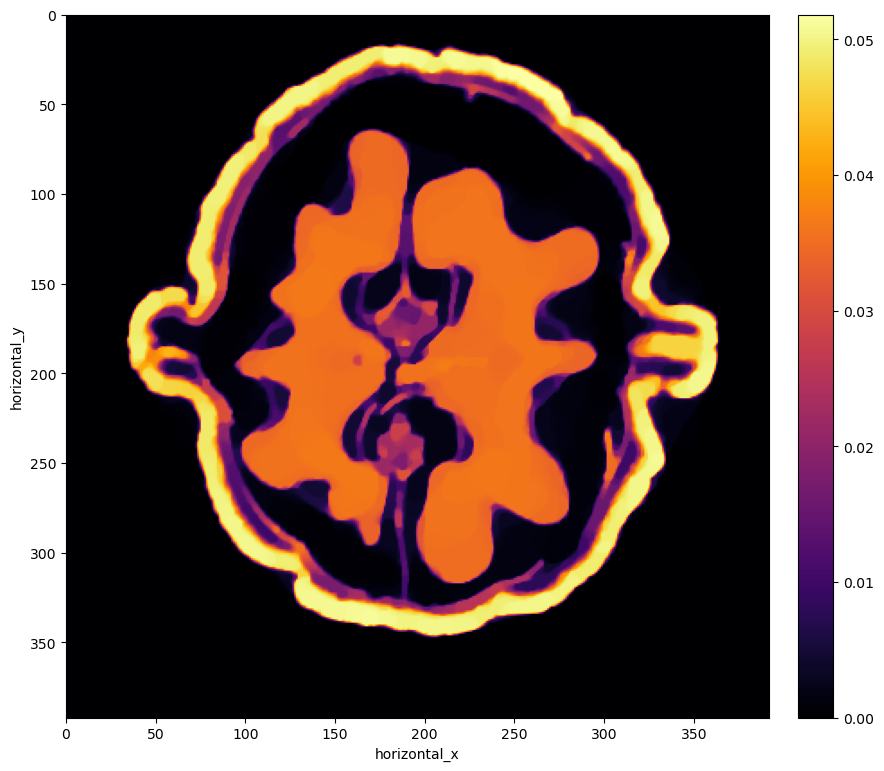

In [122]:

alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0)
F_FISTA = LeastSquares(A, b = data, c = 0.5)
step_size_fista = 1./full_objective.L

fista = FISTA(initial = initial, f=full_objective,  step_size = step_size_fista, g=G, update_objective_interval = 1, 
            max_iteration = num_epochs)
fista.run(num_epochs, verbose=1)
optimal = fista.solution
show2D(fista.solution, cmap="inferno", origin="upper")

  0%|          | 0/8000 [00:00<?, ?it/s]

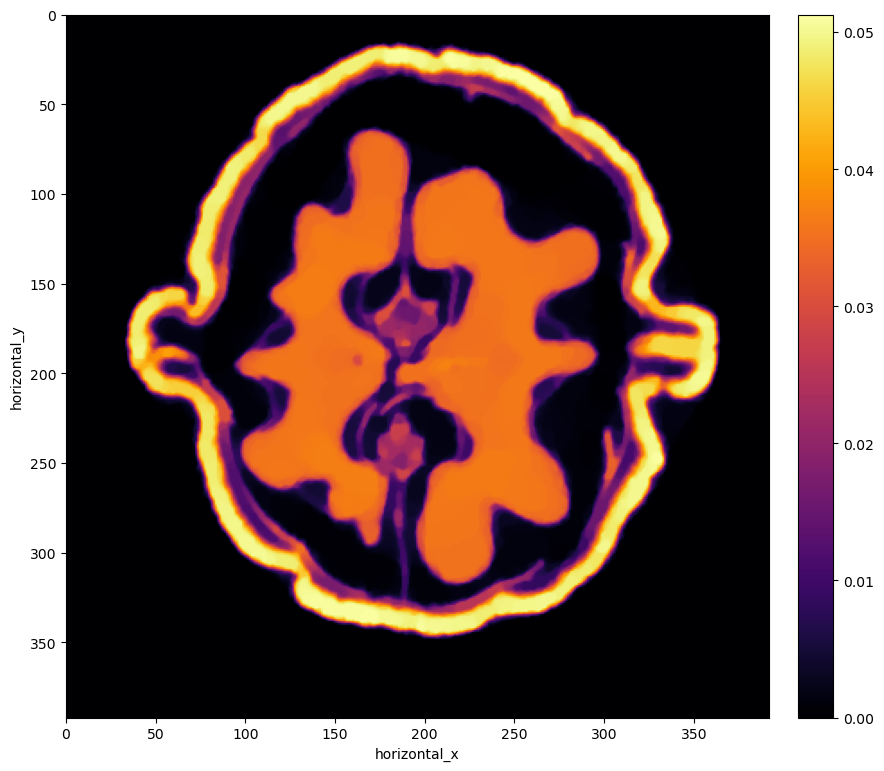

In [123]:
alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0)

step_size_ista_SG=0.99*2.0/(n_subsets*f_stochastic.L)

ista_SG = ISTA(initial = initial, f=f_stochastic, step_size = step_size_ista_SG, g=G, update_objective_interval = n_subsets, 
            max_iteration = num_epochs*n_subsets)
ista_SG.run(num_epochs*n_subsets, verbose=1)
optimalSG = ista_SG.solution
show2D(ista_SG.solution, cmap="inferno", origin="upper")

  0%|          | 0/8000 [00:00<?, ?it/s]

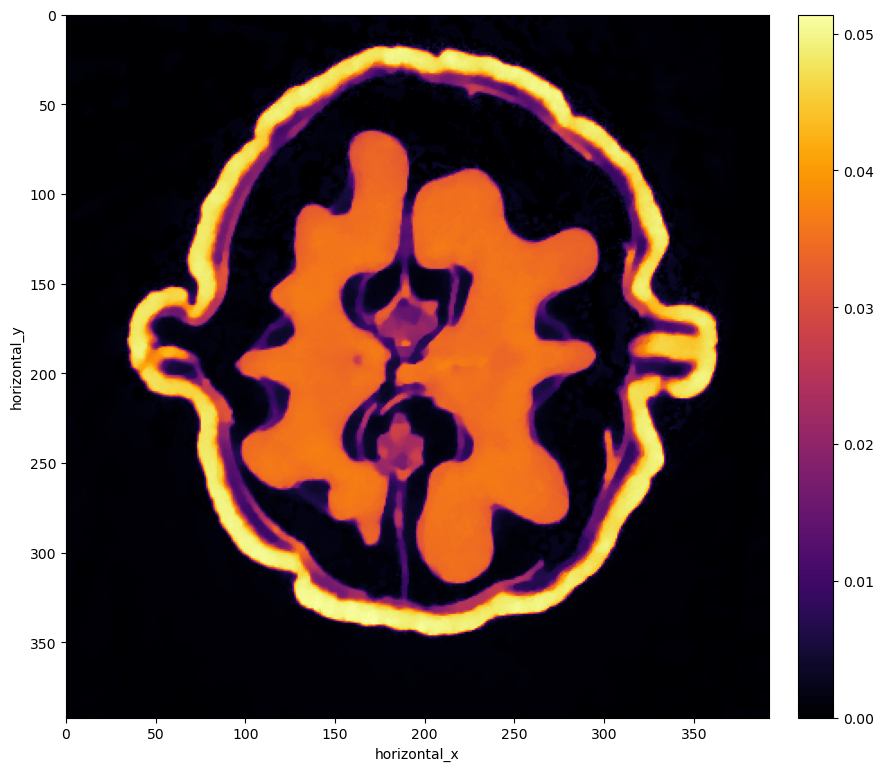

In [124]:

alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0) 

step_size_fista = 1./(n_subsets*f_stochastic.L)

fista_SG = FISTA(initial = initial, f=f_stochastic, step_size = step_size_fista, g=G, update_objective_interval = n_subsets, 
            max_iteration = num_epochs*n_subsets)
fista_SG.run(num_epochs*n_subsets, verbose=1)
optimal = fista_SG.solution
show2D(fista_SG.solution, cmap="inferno", origin="upper")

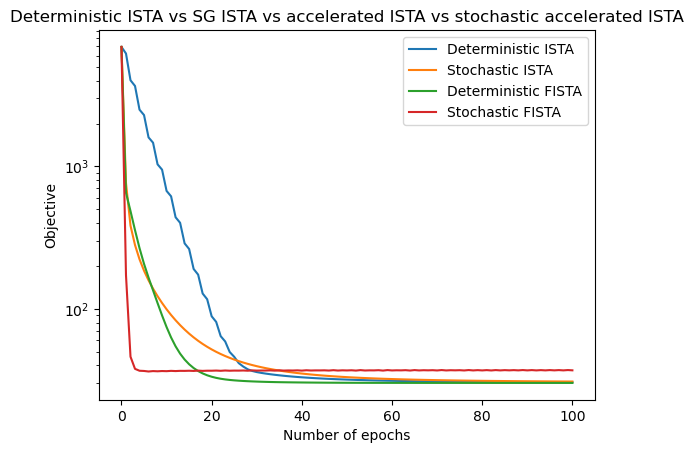

In [125]:
plt.figure()
plt.semilogy(range(0, num_epochs+1,1), ista.objective, label='Deterministic ISTA' )
plt.semilogy(range(0, num_epochs+1,1), ista_SG.objective, label='Stochastic ISTA')
plt.semilogy(range(0, num_epochs+1,1), fista.objective, label='Deterministic FISTA')
plt.semilogy(range(0, num_epochs+1,1), fista_SG.objective, label='Stochastic FISTA')
plt.xlabel('Number of epochs')
plt.ylabel('Objective')
plt.title('Deterministic ISTA vs SG ISTA vs accelerated ISTA vs stochastic accelerated ISTA')
plt.legend()
plt.show()